In [1]:
import matplotlib
import pylab
import random
import numpy as np
import matplotlib.pyplot as plt
import math

## I start with replicating the same model that the paper was using which is an ising model of a piece of Iron

In [6]:
def proposal(): #that's the proposal distribution of the monte carlo method
                # it randomly chooses spins and passes it to the boltzman dsitribution
    return np.random.randint(sim.size, size=2)

J = 6.34369e-21  # Interaction constant for iron [Joule]
kB = 1.38065e-23  # Boltzmann constant [Joule / Kelvin]

class my_ising: #building a class for the model
    def __init__(self,  T, size  ,J= 6.34369e-21):
        self.J = J
        self.size = size # this is the size of my lattice
        self.T = T
        self.config = np.zeros((self.size,self.size)) # the lattice 
        self.steps=0 # to count the number of steps
        for x in range(self.size):
            for y in range(self.size): # I start with a random configuration
                self.config[x, y] = 1 if random.random() < 0.5 else -1
                
                    
    def observe(self): #this function for observation
        pylab.cla()
        pylab.imshow(self.config, vmin = 0, vmax = 1, cmap = pylab.cm.binary)
        plt.title(f"after {self.steps} steps")
        plt.show()
        
    
    def update(self, proposal): #that's the function that will use boltzman to update the spins
        self.steps+=1
        x, y = proposal() # get the coordinate of the randomly chosen cell from the proposal distribution
        
        # calculate the energy using the equation that we used in class while assuming that the external h is 0
        energy = (
                    self.J * self.config[x, y]  *2 *(
                        self.config[(x + 1) % self.size, y] +
                        self.config[(x - 1) % self.size, y] +
                        self.config[x, (y + 1) % self.size] +
                        self.config[x, (y - 1) % self.size]))            
        
        #The boltzman distribution, the min function is just to make sure that probabilities are between 0 and 1
        if random.uniform(0, 1) < min(1,np.exp(-energy/ (T*kB) )): 
            self.config[x, y] *= -1 #changing the spin according to botlzman


## Replication of Movie 1 in the paper. The state when the temperature is less than the critical temperature (the critical temperature of Iron is 1043). At this state, m can be either +1 or -1

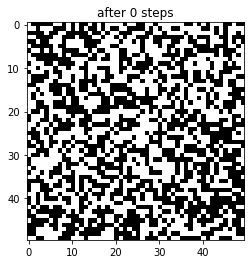

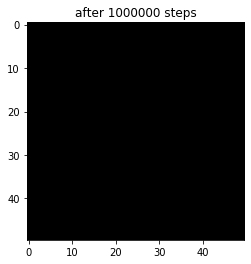

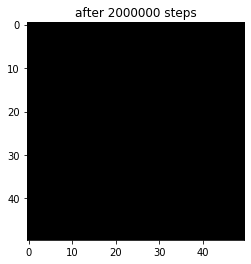

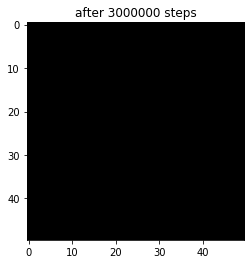

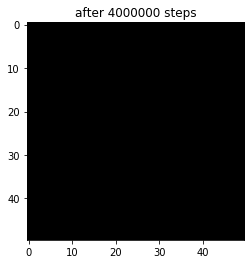

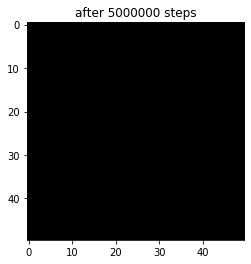

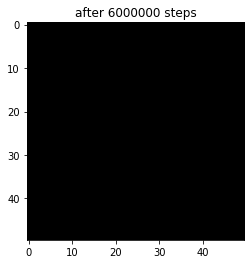

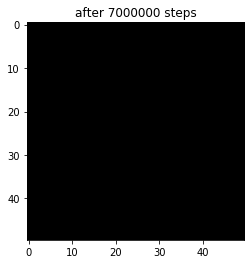

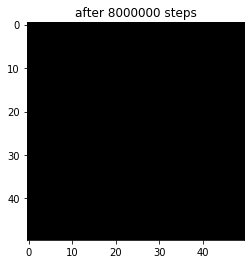

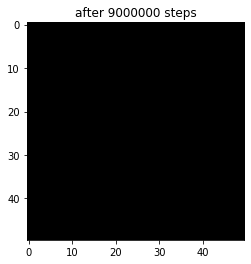

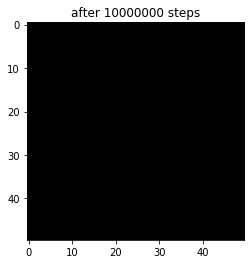

In [93]:
T = 300 #kelvins
sim = my_ising(T = 300, size = 50)
pylab.cla()
pylab.imshow(sim.config, vmin = 0, vmax = 1, cmap = pylab.cm.binary)
plt.title(f"after {sim.steps} steps")
plt.show()
for i in range(10):
    for j in range(1000000):
        sim.update(proposal)
    pylab.cla()
    pylab.imshow(sim.config, vmin = 0, vmax = 1, cmap = pylab.cm.binary)
    plt.title(f"after {sim.steps} steps")
    plt.show()


## Replication of Movie 2 in the paper. The state when temperature is equal to the critical temperature. In this state, we should see local clusters

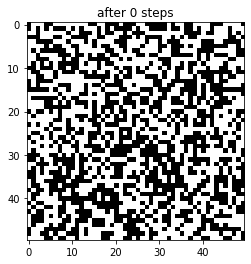

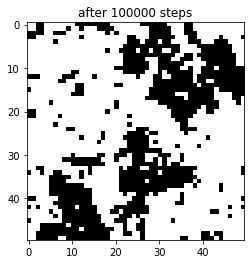

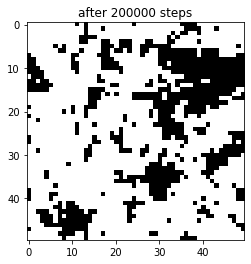

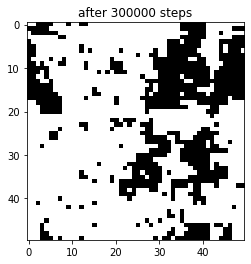

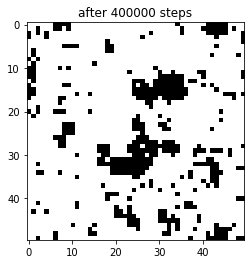

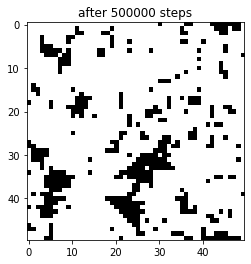

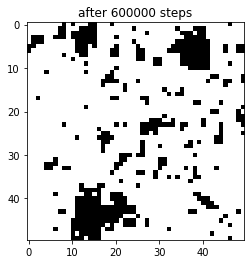

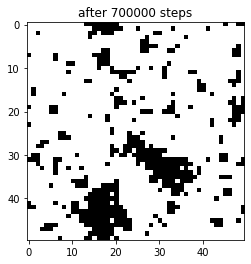

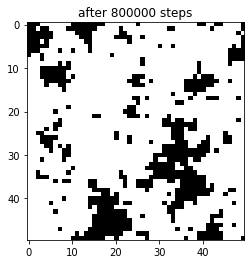

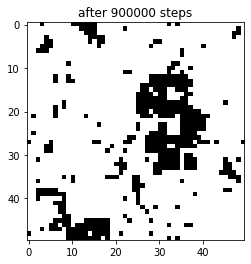

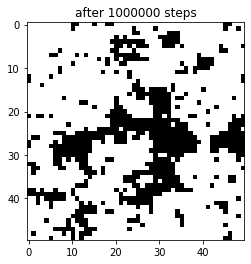

In [94]:
T = 1043 #kelvins
sim = my_ising(T = 300, size = 50)
pylab.cla()
pylab.imshow(sim.config, vmin = 0, vmax = 1, cmap = pylab.cm.binary)
plt.title(f"after {sim.steps} steps")
plt.show()
for i in range(10):
    for j in range(100000):
        sim.update(proposal)
    pylab.cla()
    pylab.imshow(sim.config, vmin = 0, vmax = 1, cmap = pylab.cm.binary)
    plt.title(f"after {sim.steps} steps")
    plt.show()


## Replicating Movie 3 in the paper. The state when the temperature is larger than the critial temperature. In this case m=0 and we should see that half of spins is up and half is down (random shape).

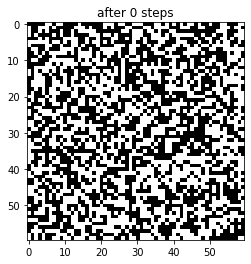

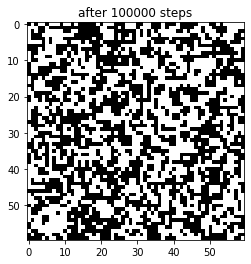

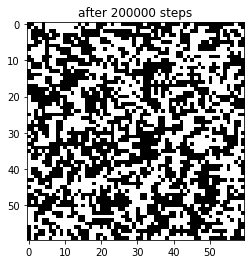

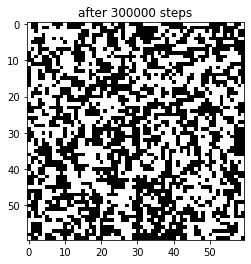

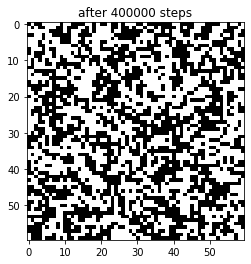

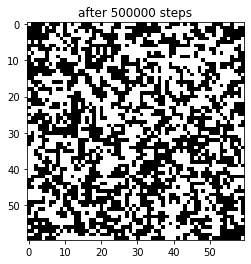

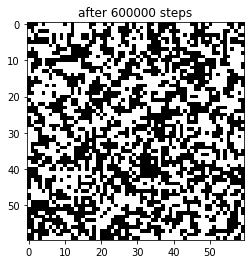

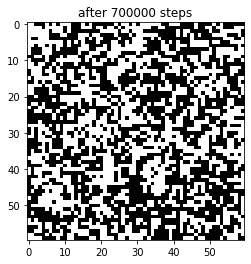

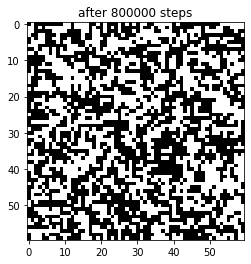

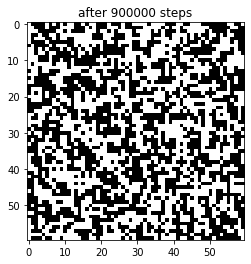

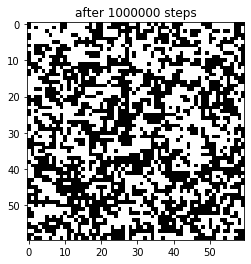

In [95]:
T = 3000
sim = my_ising(T = 300, size = 60)
pylab.cla()
pylab.imshow(sim.config, vmin = 0, vmax = 1, cmap = pylab.cm.binary)
plt.title(f"after {sim.steps} steps")
plt.show()
for i in range(10):
    for j in range(100000):
        sim.update(proposal)
    pylab.cla()
    pylab.imshow(sim.config, vmin = 0, vmax = 1, cmap = pylab.cm.binary)
    plt.title(f"after {sim.steps} steps")
    plt.show()


## Now, I implement the Ising model but this time using the Wolff cluster algorithm. The wolff cluster algorithm is a much more efficient algorithm in terms of improving the proposal distribution. The trick of the algorithm is that it has 100% acceptance rate which means that all proposals are accepted and their spins is changed at every state. The algorithm basically works the following:
- Pick a random cell in the grid
- Go through each neighbor of that cell, if it has the same spin, then add it to the cluster and put it in your pocket with a probability P
- Go through each cell in your pocket and repeat the step above for each one of them
- Once you are done, change the spin of the entire cluster and repeat again.

In [57]:

class WolffIsing:

    J = 6.34369e-21  # Interaction constant for iron [Joule]
    kB = 1.38065e-23  # Boltzmann constant [Joule / Kelvin]

    def __init__(self, size=100, temperature=300):
        
        self.size = size
        self.set_temperature(temperature) #starting randomly again
        self.state = np.random.choice(
            [-1, +1], size=(self.size, self.size))
        self.step = 0
        self.total_flips = 0



    def energy(self): # energy using the equation from class, still putting h=0
        
        return -self.J * (self.state * (
            np.roll(self.state, 1, axis=0) +
            np.roll(self.state, 1, axis=1))).sum()

    
    # the average magnetization to make a nice plot in hope of more good greades in #StatisicalSimulation :D
    def average_m(self): 
        return self.state.mean() # since my state is just a numpy array of +1 or -1 then taking their mean
                                # is the average magentization  

    def update(self):# This perfoms a single cluster update
        
        # Pick a random cell to start the cluster
        i, j = np.random.randint(self.size, size=2)
        cell_value = self.state[i, j]
        cluster = {(i, j)} #dictionary to contain the cluster
        pocket = [(i, j)] # pocket to put the neighboring cells to search their neirghbors

        while len(pocket) > 0:
            # Get a random cell from the pocket
            i, j = pocket.pop(np.random.randint(0, len(pocket)))
            # Check whether to add any of the cell's neighbors to the cluster
            for u, v in [
                ((i - 1) % self.size, j),
                ((i + 1) % self.size, j),
                (i, (j - 1) % self.size),
                (i, (j + 1) % self.size)
            ]:
                if (   # if same spin and it's not already in the cluster
                    (self.state[u, v] == cell_value) and
                    ((u, v) not in cluster) and
                    (np.random.uniform(0, 1) < self.cluster_prob)
                ):
                    pocket.append((u, v)) # add it to the pocket
                    cluster.add((u, v))  # and to the cluster
        # Flip all cells in the cluster
        for (i, j) in cluster:
            self.state[i, j] = -cell_value
        self.step += 1
        self.total_flips += len(cluster)

    def observe(self):
        
        plt.figure()
        plt.imshow(self.state, vmin=-1, vmax=+1)
        plt.title(f"after {self.step} steps")

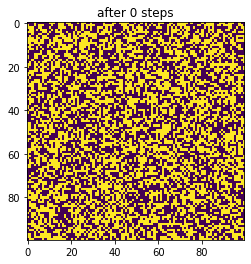

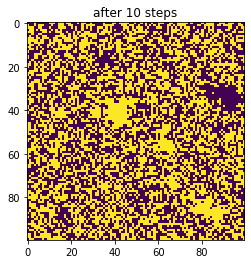

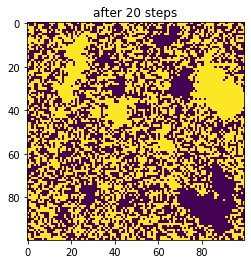

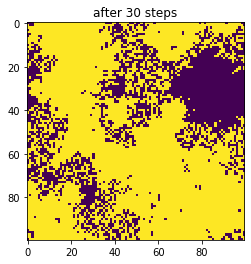

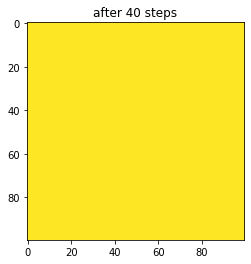

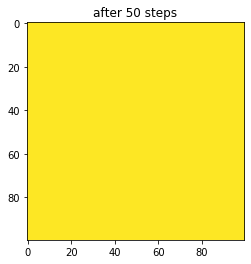

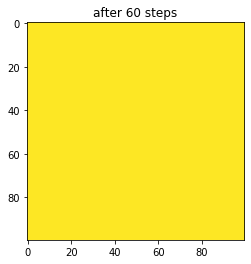

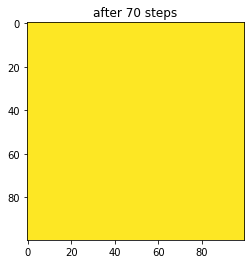

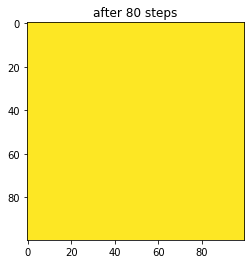

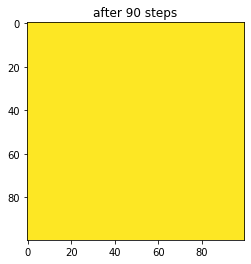

In [58]:
sim = WolffIsing(temperature = 300)
for j in range(10):
    sim.observe()
    for i in range(10):
        sim.update()


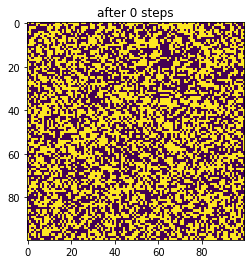

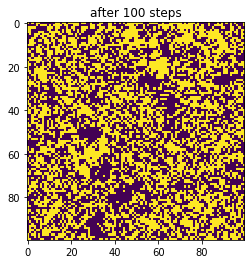

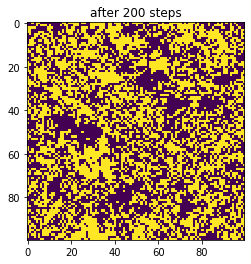

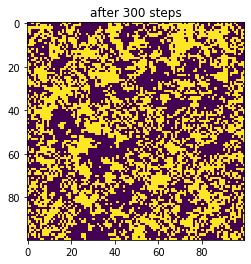

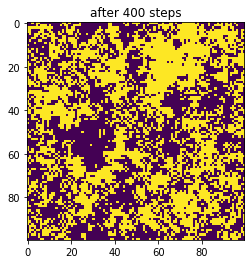

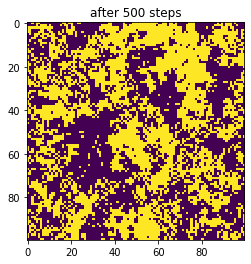

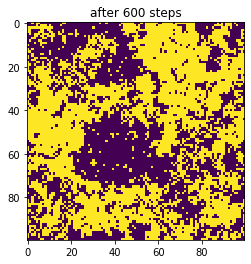

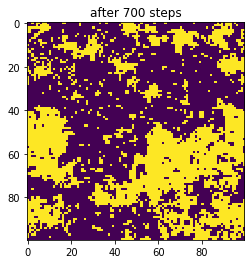

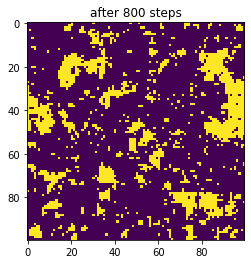

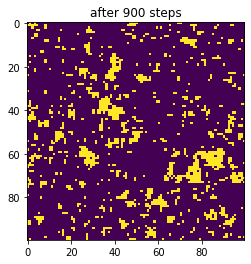

In [30]:
sim = WolffIsing(temperature = 1043)
for j in range(10):
    sim.observe()
    for i in range(100):
        sim.update()


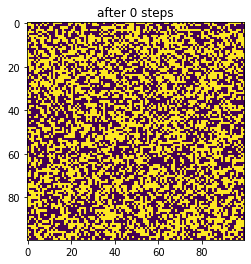

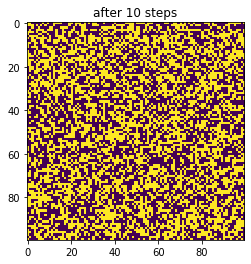

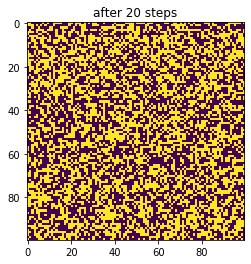

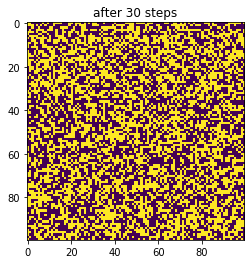

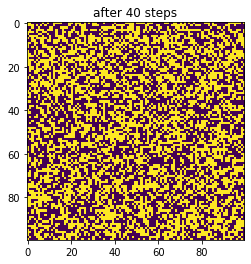

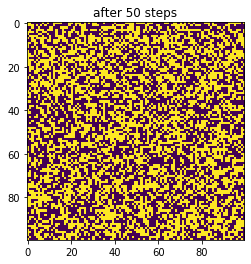

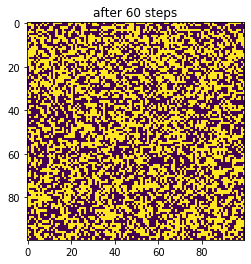

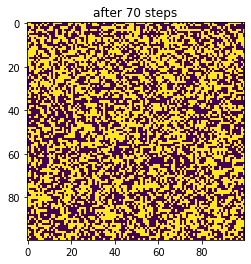

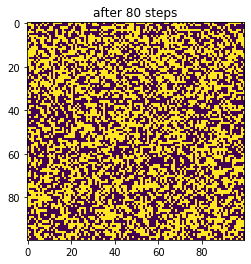

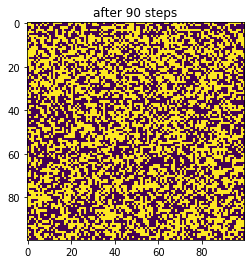

In [29]:
sim = WolffIsing(temperature = 3000)
for j in range(10):
    sim.observe()
    for i in range(10):
        sim.update()


In [74]:
avg_300 = []
for j in range(10):
    sim = WolffIsing(temperature = 300)
    for i in range(100):
        sim.update()
    avg_300.append(sim.average_m())
 

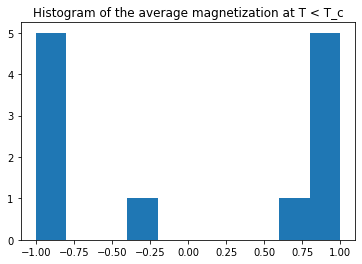

In [92]:
plt.hist(avg_300)
plt.title("Histogram of the average magnetization at T < T_c")
plt.show()

In [86]:
avg_3000 = []
for j in range(1000):
    sim = WolffIsing(temperature = 3000)
    for i in range(100):
        sim.update()
    avg_3000.append(sim.average_m())
 

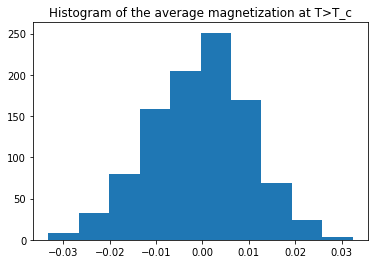

In [90]:
plt.hist(avg_3000)
plt.title("Histogram of the average magnetization at T>T_c")
plt.show()